In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"

In [2]:
import numpy as np
import torch
import pyBigWig
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sys
sys.path.append('../2_train_models')
from data_loading import read_fasta_fast, one_hot_encode
from file_configs import FoldFilesConfig

sys.path.append("../3_eval_models")
from eval_utils import model_predict_with_rc

sys.path.append('../4_interpret_models')
from captum.attr import DeepLiftShap
from deepshap_utils import ProfileModelWrapper
from dinuc_shuffle import dinuc_shuffle

from other_motif_utils import plot_motif_on_ax

In [3]:
# specify what set of models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

In [4]:
# Load the config objects (filepaths holders) for each fold a model was trained on

def load_fold_configs(cell_type, timestamps,
                      model_type = model_type, data_type = data_type):

    fold_configs = []
    for fold_i, timestamp in enumerate(timestamps):
        # folds are 1-indexed, and config constructor is expecting a string
        fold = str(fold_i + 1)
        
        # load the config object for this specific fold / model
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        fold_configs.append(config)
        
    return fold_configs

fold_configs = load_fold_configs(cell_type, timestamps)

Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


In [5]:
# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = fold_configs[0].proj_dir

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

In [6]:
### Data Loading

def load_sequence_at_locus(chrom, start, end, genome_path):
    # load (forward strand) genomic sequence between start and end coords
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    # seq is a string
    seq = genome[chrom][start:end]
    
    # one-hot encode the sequence string (returns numpy array)
    onehot_seq = one_hot_encode(seq).T
    
    # after transposing, onehot_seq is shape (4, end - start)
    return seq, onehot_seq


def load_observed_profile_at_locus(chrom, start, end, plus_bw_path, minus_bw_path):
    # load the positive-strand PRO-cap data between the start and end coords
    with pyBigWig.open(plus_bw_path, "r") as plus_bw:
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
    plus_sig = np.nan_to_num(plus_sig)

    # repeat for the negative strand
    with pyBigWig.open(minus_bw_path, "r") as minus_bw:
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
    minus_sig = np.nan_to_num(minus_sig)

    # combine into array of shape (2, end - start)
    signal = np.array([plus_sig, minus_sig])
    return signal


def get_locus_data(chrom, start, end, config,
                   in_window=in_window, out_window=out_window):
    # loads sequence and observed data, *centered* between start and end coords
    
    genome_path = config.genome_path
    plus_bw_path = config.plus_bw_path
    minus_bw_path = config.minus_bw_path
    
    # calculate sequence coordinates so they'll match model input size
    mid = (start + end) // 2
    seq_start = mid - in_window // 2
    seq_end = seq_start + in_window
    seq, onehot_seq = load_sequence_at_locus(chrom, seq_start, seq_end,
                                             genome_path)
    
    # calculate profile coordinates so they'll match model output size
    prof_start = mid - out_window // 2
    prof_end = prof_start + out_window
    prof = load_observed_profile_at_locus(chrom, prof_start, prof_end,
                                          plus_bw_path, minus_bw_path)
    
    return seq, onehot_seq, prof


# The example we will plot: MYC promoter coordinates
chrom, start, end = ["chr8", 127735875, 127736475]

# Load everything before doing any motif ablation (og = original)
og_seq, og_onehot_seq, og_prof = get_locus_data(chrom, start, end, fold_configs[0])

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


In [7]:
### Model Prediction

def load_model(config):
    model = torch.load(config.model_save_path)
    model.eval()
    model = model.cuda()
    return model

def predict_merge_across_folds(onehot_seq, fold_configs):
    pred_profs_across_folds = []
    pred_logcounts_across_folds = []
    
    #onehot_seq = torch.tensor(onehot_seq, dtype=torch.float32)
    onehot_seq = onehot_seq[None,...]
    
    # for each fold model...
    for config in fold_configs:
        model = load_model(config)
        
        with torch.no_grad():
            pred_profs, pred_logcounts = model_predict_with_rc(model, onehot_seq)

        pred_prof = np.exp(pred_profs.squeeze())
        pred_profs_across_folds.append(pred_prof)
        pred_logcounts_across_folds.append(pred_logcounts)
        
    # take the mean prediction across all folds
    merged_pred_prof = np.array(pred_profs_across_folds).mean(axis=0)
    merged_pred_logcounts = np.array(pred_logcounts_across_folds).mean(axis=0)
    
    # combine profile and counts outputs into one prediction
    scaled_pred_prof = merged_pred_prof * np.exp(merged_pred_logcounts)
    return scaled_pred_prof


# get model prediction on original genomic sequence (before any motif ablation)
og_pred_prof = predict_merge_across_folds(og_onehot_seq, fold_configs)

In [8]:
def deepshap(seq, model):
    # run deepshap on a single sequence
    # this function uses the profile task by default (cleaner scores)
    
    prof_shap_explainer = DeepLiftShap(ProfileModelWrapper(model))
    
    if len(seq.shape) < 3:
        seq = seq[None,...]

    # reference will be 25 dinucleotide-shuffled sequences
    ref_seqs = dinuc_shuffle(seq[0], 25).float().cuda()
    prof_attrs = prof_shap_explainer.attribute(seq.cuda(), ref_seqs).cpu()
    
    # project scores onto the sequence
    prof_attrs = prof_attrs * seq
    
    return prof_attrs.squeeze().detach().numpy()


def deepshap_merge_across_folds(onehot_seq, fold_configs):
    prof_deepshap_across_folds = []
    
    onehot_seq = torch.tensor(onehot_seq).float()
    
    # for each fold model...
    for config in fold_configs:
        model = load_model(config)
        scores = deepshap(onehot_seq, model)
        prof_deepshap_across_folds.append(scores)

    # take mean of scores across all model folds
    merged_prof_deepshap = np.array(prof_deepshap_across_folds).mean(axis=0)
    return merged_prof_deepshap


# get profile contribution scores before any motif ablation
og_prof_attr = deepshap_merge_across_folds(og_onehot_seq, fold_configs)

/users/kcochran/miniconda3/envs/procap_A100/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [9]:
### What Sequence Mutations To Test

# order: downstream Inr, downstream TATA, upstream TATA, downstream BRE, TCT, antisense Inr

# the start (leftmost) position in the sequence to start replacing bases at
# (these are relative to the sequence, so in_window / 2 or 1057 would be the center)

mutate_positions = [1111, 1083, 923, 1065, 1111, 1000]

# the sequence to replace the original genomic sequence with
# (order must match the order of mutate_positions)

mutate_seqs = ["GGG", "GGGG", "CGGC", "CTAGCTA", "TTCTTTT", "A"]
mutate_lens = [len(seq) for seq in mutate_seqs]

# description of each of the mutations in the lists above (figure labels)

mutate_labels = ["Right Inr\nAblated",
                 "Right TATA\nAblated",
                 "Left TATA\nAblated",
                 "Right BRE/SP\nAblated",
                 "Right Inr\nTurned TCT",
                 "Cryptic Inr\nImproved"]

assert len(mutate_positions) == len(mutate_seqs)
assert len(mutate_seqs) == len(mutate_labels)

In [10]:
def mutate_sequence(og_onehot_seq, mutate_pos, mutate_to):
    # expecting a numpy array one-hot encoded sequence, an int, and a string
    assert type(mutate_to) == str, type(mutate_to)
    
    # to the left of mutation, sequence is untouched
    new_seq_onehot = [og_onehot_seq[:, :mutate_pos]]
    
    # add mutated sequence instead of original sequence
    new_seq_onehot += [one_hot_encode(mutate_to).T]
    
    # to the right of mutation, sequence is also untouched
    new_seq_onehot += [og_onehot_seq[:, mutate_pos + len(mutate_to):]]
    
    # combine chunks of sequence into one array
    new_seq_onehot = np.concatenate(new_seq_onehot, axis=-1)
    return new_seq_onehot
    

def get_mutated_prof_preds_and_attrs(og_onehot_seq, mutate_positions, mutate_seqs, fold_configs):
    # for every sequence mutation we want to test,
    #  1) make the mutated sequence
    #  2) make new model predictions and contrib. scores for that mutated sequence
    
    pred_profs = []
    attrs = []
    for mutate_pos, mutate_to in zip(mutate_positions, mutate_seqs):
        # make the changed sequence
        new_seq_onehot = mutate_sequence(og_onehot_seq, mutate_pos, mutate_to)

        # re-calculate model predictions and contribution scores
        pred_prof = predict_merge_across_folds(new_seq_onehot, fold_configs)
        pred_profs.append(pred_prof)

        attr = deepshap_merge_across_folds(new_seq_onehot, fold_configs)
        attrs.append(attr)
        
    return pred_profs, attrs

mutate_pred_profs, mutate_attrs = get_mutated_prof_preds_and_attrs(og_onehot_seq,
                                                                   mutate_positions,
                                                                   mutate_seqs,
                                                                   fold_configs)

In [11]:
def slice_to_prof_len(attrs, prof_len = out_window):
    # Attributions are along the sequence axis, so their length
    # is the same as the model input. For plots, we want them to
    # be trimmed to the size of the model output instead.
    
    # lazy check that we have the right axis
    assert attrs.shape[-1] >= prof_len, attrs.shape
    
    # center the trimming
    mid = attrs.shape[-1] / 2
    prof_start = int(mid - prof_len / 2)
    prof_end = prof_start + prof_len
    
    return attrs[..., prof_start : prof_end]


def plot_prof_on_ax(profile, ax, zoom_start, zoom_end,
                    color = "#001DAC", alphas = [1, 0.6],
                    linewidth=0.9, x_axis_buffer=0):
    
    # the + 0.5 is so the profiles are right on top of the bases of the scores
    x_range = np.arange(zoom_start, zoom_end) + 0.5
    
    # when both strands have data at 0, they'll plot on top of each other.
    # this offset is the minimum needed to uniformly add to the plotting
    # of both strands so that when the lines are at 0, they're both still visible
    offset = np.max(np.abs(profile[:, zoom_start:zoom_end])) * 0.02
    
    # plot positive strand
    ax.plot(x_range, profile[0, zoom_start:zoom_end] + offset,
            alpha = alphas[0], c = color, linewidth=linewidth)
    # plot negative strand
    ax.plot(x_range, -1 * profile[1, zoom_start:zoom_end] - offset,
            alpha = alphas[1], c = color, linewidth=linewidth)

    ax.set_xlim(zoom_start - x_axis_buffer, zoom_end + x_axis_buffer)
    
    
def get_prof_plot_lims(profs, zoom_start, zoom_end):
    # figure out what the range of the y-axis should be, so that
    # it includes the most extreme values in every profile we will plot
    
    pos_strand_max = 0
    neg_strand_max = 0
    
    # figure out the maximum across any profile, for each strand
    for prof in profs:
        pos_strand_max = max(pos_strand_max, np.max(prof[0, zoom_start:zoom_end]))
        neg_strand_max = max(neg_strand_max, np.max(prof[1, zoom_start:zoom_end]))
    
    return -1 * neg_strand_max, pos_strand_max 


def get_attr_plot_lims(attrs, zoom_start, zoom_end):
    # same as get_prof_plot_lims() but for the contribution score tracks
    
    # we don't have two strands, but values can be positive or negative
    pos_max = 0
    neg_max = 0
    
    for attr in attrs:
        attr = slice_to_prof_len(attr)
        pos_max = max(pos_max, np.max(attr[:, zoom_start:zoom_end]))
        neg_max = min(neg_max, np.min(attr[:, zoom_start:zoom_end]))
    return neg_max, pos_max 

findfont: Font family ['Arial Rounded'] not found. Falling back to DejaVu Sans.


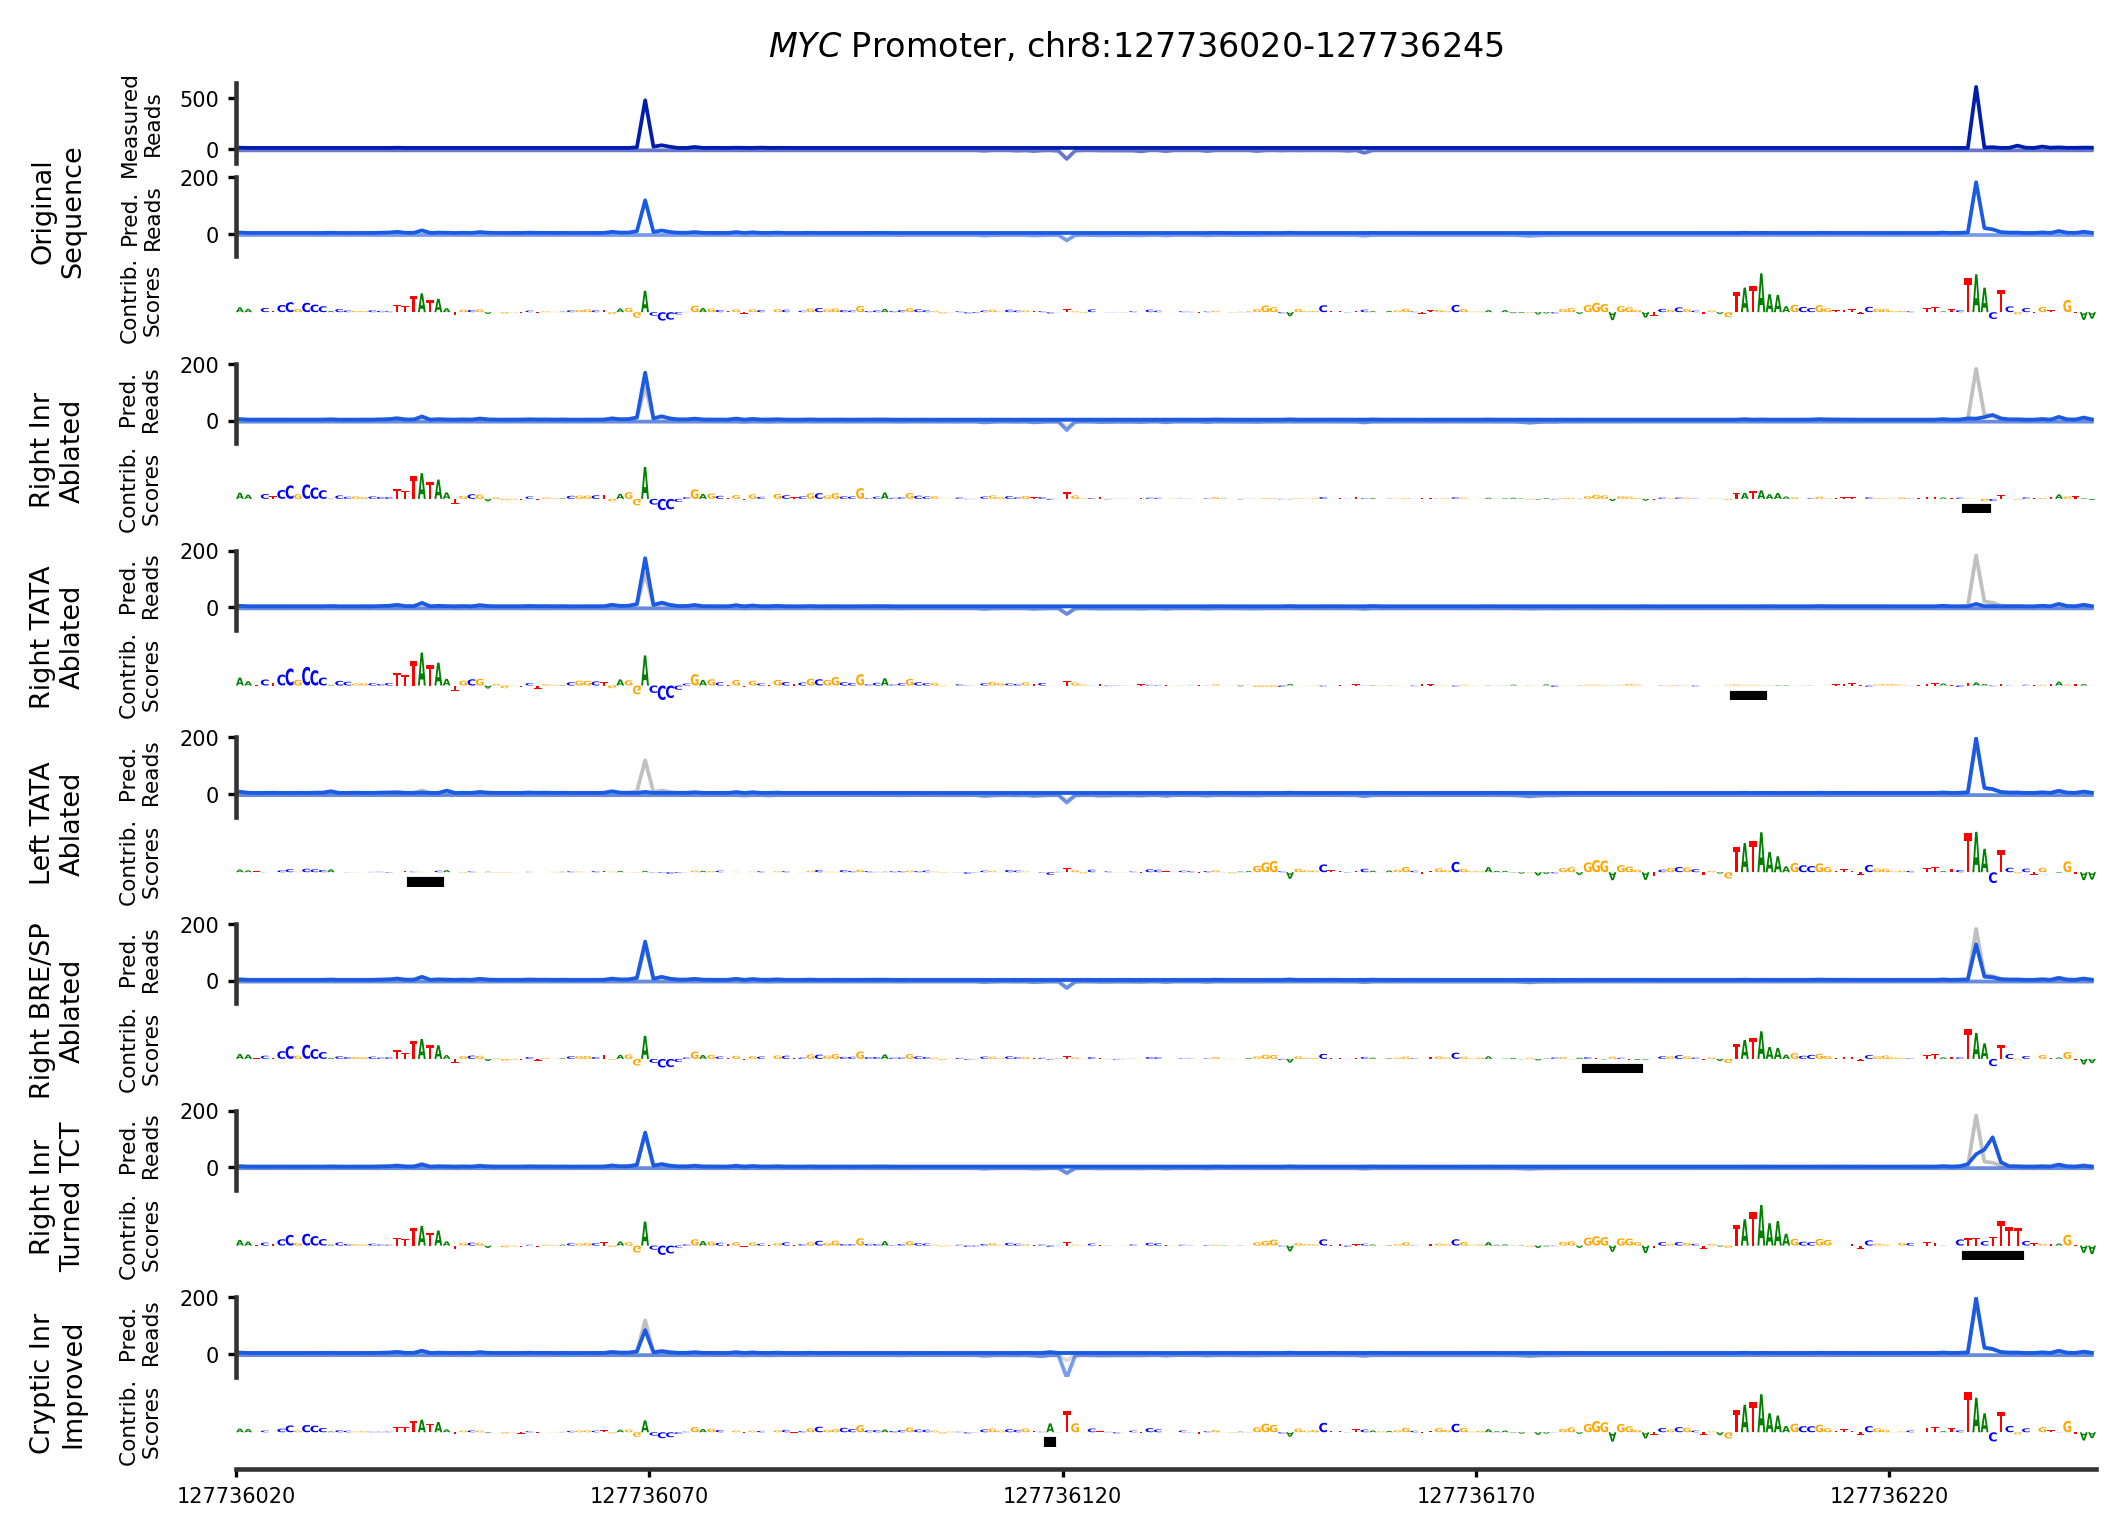

In [12]:
def plot_mutate_effect_with_attrs(og_seq, og_onehot_seq,
                                  true_profile, og_pred_profile, og_prof_attr,
                                  mutate_pred_profs, mutate_attrs, mutate_labels,
                                  mutate_positions, mutate_lens,
                                  prof_len = out_window, save_path = None,
                                  zoom_midpoint = 457, zoom_width = 225):
    
    assert len(mutate_pred_profs) == len(mutate_attrs), (len(mutate_pred_profs), len(mutate_attrs))
    assert len(mutate_positions) == len(mutate_lens), (len(mutate_positions), len(mutate_lens))
    
    plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
    plt.rcParams.update(plot_params)
    axis_fontsize = 5.2
    axis_labelpad = 4
    axis_index = 0
    
    
    # total plot-rows: (original data, pred, and scores), and then (pred, scores) for each mutation
    num_subplots = 3 + 2 * len(mutate_positions)
    
    # BUT to put spacing between each mutation's rows, we will have an extra insivible thin row
    num_actual_subplots = 3 + 3 * len(mutate_positions)
    
    # [10,10,7] --> (original data, pred, scores)
    # [1,10,7] --> (invisible spacing, pred, scores) for each mutation
    height_ratios = [10,10,7] + [1,10,7] * len(mutate_positions) + [1]
    
    
    fig = plt.figure(figsize=(8, 0.4 * num_subplots), dpi=300)
    gs = fig.add_gridspec(num_actual_subplots + 1, height_ratios = height_ratios, hspace=0.3)
    axes = gs.subplots()

    # use eyeballs to figure out what exact bases you want to plot
    # plto will show region that is (zoom_midpoint - zoom_width/2, zoom_midpoint + zoom_width/2)
    zoom_start = min(max(zoom_midpoint - zoom_width//2, 0), prof_len - zoom_width)
    zoom_end = zoom_start + zoom_width
    genomic_start = (start + end) // 2 - out_window // 2
    
    title = r'$\it{MYC}$ Promoter, ' + chrom + ":" + str(genomic_start + zoom_start) + "-" + str(genomic_start + zoom_end)
    fig.suptitle(title, y = 0.91, fontsize=8, horizontalalignment='center')
    
    # figure out what you want the y-axis range of the predicted profiles to consistently be
    pred_prof_min, pred_prof_max = get_prof_plot_lims([og_pred_profile] + mutate_pred_profs,
                                                      zoom_start, zoom_end)
    
    # all this nice generalizable code is no match for matplotlib choosing a weird-looking axis tick
    # sorry hardcoding the axis limit to look less dumb for MYC example
    if 200 - pred_prof_max < 10:
        pred_prof_max = 200
    
    # repeat for attributions
    attr_min, attr_max = get_attr_plot_lims([og_prof_attr] + mutate_attrs,
                                            zoom_start, zoom_end)
    
    
    # plot original observed data
    
    plot_prof_on_ax(true_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "#001DAC")
    
    axes[axis_index].set_ylabel("Measured\nReads", fontsize = axis_fontsize,
                                rotation=90, labelpad=axis_labelpad)
    axis_index += 1
    
    
    # plot original model prediction
    
    plot_prof_on_ax(og_pred_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "#1B5AE3")
    
    axes[axis_index].set_ylabel("Pred.\nReads", fontsize = axis_fontsize,
                                rotation=90, labelpad=axis_labelpad)
    axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
    axis_index += 1
    
    
    # plot original contribution scores
    
    og_prof_attr = slice_to_prof_len(og_prof_attr)[:, zoom_start : zoom_end].T
    plot_motif_on_ax(og_prof_attr, axes[axis_index])
    
    axes[axis_index].set_ylabel("Contrib.\nScores",
                                fontsize = axis_fontsize, rotation=90,
                                labelpad=axis_labelpad)
    axes[axis_index].set_ylim(attr_min, attr_max)
    axes[axis_index].text(-22, attr_max, "Original\nSequence",
                          ha="center", fontsize=6.5, rotation=90)
    axis_index += 1
    
    
    # then repeat for all of the sequence mutations: plot predicted profiles + scores
    
    for mutation_num in range(len(mutate_labels)):
        mutate_prof = mutate_pred_profs[mutation_num]
        mutate_attr = mutate_attrs[mutation_num]
        label = mutate_labels[mutation_num]
        mutate_pos = mutate_positions[mutation_num]
        mutate_len = mutate_lens[mutation_num]
        
        # skip the invisible spacer axis
        axis_index += 1
        
        
        # plot model prediction
        
        # original prediction, grayed out
        plot_prof_on_ax(og_pred_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "silver")
        # new prediction after mutation
        plot_prof_on_ax(mutate_prof, axes[axis_index], zoom_start, zoom_end,
                        color = "#1B5AE3")
        
        axes[axis_index].set_ylabel(" Pred.\n Reads", fontsize = axis_fontsize,
                                    rotation=90, labelpad=axis_labelpad)
        axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
        axis_index += 1
        
        
        # plot contribution scores
        
        mutate_attr = slice_to_prof_len(mutate_attr)[:, zoom_start : zoom_end].T
        plot_motif_on_ax(mutate_attr, axes[axis_index])
        
        axes[axis_index].set_ylabel("Contrib. \nScores ",
                                    fontsize = axis_fontsize, rotation=90,
                                    labelpad=axis_labelpad)
        axes[axis_index].set_ylim(attr_min, attr_max)
        
        # highlight where ablation happened with black rectangle
        #axes[axis_index].add_patch(Rectangle((mutate_pos - zoom_start - 0.5, -0.075),
        #                                     mutate_len, 0.5,
        #                                     color="k"))
        yrange = axes[axis_index].get_ylim()[1] - axes[axis_index].get_ylim()[0]
        axes[axis_index].add_patch(Rectangle((mutate_pos - zoom_start - 0.5 - (in_window - out_window) / 2,
                                              axes[axis_index].get_ylim()[0] * 1.65), 
                                             mutate_len,
                                             yrange * 0.3,
                                             color="k"))
        
        # add the outer-y-axis-label looking text to describe the mutation
        axes[axis_index].text(-22, attr_max * 1.2, label,
                              ha="center", va="center",
                              fontsize=6.5, rotation=90)
        
        axis_index += 1
        
    
    # aesthetics below
    
    # fix off-by-one error from loop above (no spacing subplot after last set of subplots)
    axis_index -= 1 
    
    xticks = np.arange(0, zoom_end - zoom_start, 50)
    xticklabels = np.array([int(tick_pos + zoom_start + genomic_start) for tick_pos in xticks])

    for ax_i, ax in enumerate(axes):
        ax.tick_params(length=2, pad=2, labelsize=5)
        
        if height_ratios[ax_i] == 1:  # is this one of the spacing subplots?
            ax.spines["left"].set_visible(False)
            ax.set_yticks([])
        else:
            ax.spines["left"].set_linewidth(1.1)
            ax.spines["left"].set_color("#333333")
        ax.spines[["top", "right"]].set_visible(False)
        
        if ax_i == len(axes) - 1:
            ax.set_xlim(0, zoom_end - zoom_start)
            ax.set_xticks(xticks, xticklabels)
            ax.spines["bottom"].set_linewidth(1.1)
            ax.spines["bottom"].set_color("#333333")
        else:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
    
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)

    plt.show()

    
plot_mutate_effect_with_attrs(og_seq, og_onehot_seq,
                              og_prof, og_pred_prof, og_prof_attr,
                              mutate_pred_profs, mutate_attrs, mutate_labels,
                              mutate_positions, mutate_lens,
                              prof_len = out_window, save_path = figures_dir + "4_myc.png")

### Quantification

In [14]:
# positions of the main two TSSs on the pos. strand:
og_pred_prof[0][394], og_pred_prof[0][555]

(115.254166, 179.03587)

In [15]:
# % loss in downstream TSS after Inr ablation
1 - mutate_pred_profs[0][0][555] / og_pred_prof[0][555]

0.9783477932214737

In [16]:
# % loss in downstream TSS after right TATA ablation
1 - mutate_pred_profs[1][0][555] / og_pred_prof[0][555]

0.9515686817467213

In [17]:
# % loss in downstream TSS after right BRE ablation
1 - mutate_pred_profs[3][0][555] / og_pred_prof[0][555]

0.2984812259674072

In [18]:
# % change in downstream TSS after Inr -> TCT 
1 - np.sum(mutate_pred_profs[3][0][553:558]) / og_pred_prof[0][555]

0.16921663284301758

In [19]:
# % loss in UPstream TSS after LEFT TATA ablation
1 - mutate_pred_profs[2][0][394] / og_pred_prof[0][394]

0.9680968336760998

In [20]:
# Redistribution: % increase in UPstream TSS after right Inr ablation
mutate_pred_profs[0][0][394] / og_pred_prof[0][394]

1.4400598

In [21]:
# Redistribution: % increase in UPstream TSS after right TATA ablation
mutate_pred_profs[1][0][394] / og_pred_prof[0][394]

1.473903

In [22]:
# Redistribution: % increase in UPstream TSS after cryptic Inr improvement
1 - mutate_pred_profs[-1][0][394] / og_pred_prof[0][394]

0.2991076111793518

In [23]:
# Redistribution: % increase in UPstream TSS after cryptic Inr improvement
mutate_pred_profs[-1][0][555] / og_pred_prof[0][555]

1.0770024